In [1]:
import pandas as pd
import seaborn as sns
import glob
import numpy as np
import scipy.stats as stats
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import probplot
from scipy.stats import zscore

## Preprocessing

In [2]:
# Get a list of all csv files in the data directory 

files = glob.glob('data/*.csv')

In [3]:
#List to hold the DataFrame
dfs = []

#Loop through each file, read it into a DataFrame and skip the first row 
for file in files:
    i_df = pd.read_csv(file, encoding='utf-8', engine='python')
    dfs.append(i_df)
    
#Concatenate the DataFrames into a single DataFrame
pre_df = pd.concat(dfs, ignore_index=True)

In [4]:
#pivot determinants 
df_wide = pre_df.pivot_table(index=['sample.samplingPoint.label','sample.sampleDateTime','sample.samplingPoint.easting','sample.samplingPoint.northing'],columns='determinand.label',
                           
                           values='result'
                           )

In [5]:
# drop columns with more than 90% null values 

missing_percent = df_wide.isnull().sum()/len(df_wide)
df_missing = pd.DataFrame({'column_name': df_wide.columns,
                                 'missing_percent': missing_percent})
threshold = 0.90
col_ndrop = df_missing[missing_percent<threshold]
col_ndrop

,column_name,missing_percent
determinand.label,,
Alky pH 4.5,Alky pH 4.5,0.790536
Ammonia(N),Ammonia(N),0.479705
BOD ATU,BOD ATU,0.456884
COD as O2,COD as O2,0.786017
Chloride Ion,Chloride Ion,0.875309
Cond @ 25C,Cond @ 25C,0.755462
N Oxidised,N Oxidised,0.707908
NH3 un-ion,NH3 un-ion,0.800352
Nitrate-N,Nitrate-N,0.743012


In [7]:
# List of column names to keep
cols_to_keep = ['Ammonia(N)']

# Select only the desired columns
df_wide = df_wide[cols_to_keep]

In [12]:
df_wide['Ammonia(N)'].isnull().sum()

396090

In [13]:
df_wide.shape

(825695, 1)

In [15]:
#convert the index columns to dataset columns
df_wide_index = df_wide.reset_index().rename(columns={'index': 'sample.sampleDateTime'})

In [16]:
df_wide_index

determinand.label,sample.samplingPoint.label,sample.sampleDateTime,sample.samplingPoint.easting,sample.samplingPoint.northing,Ammonia(N)
0,"(A) WINNING COLLIERY, MINEWATER",2016-10-27T13:00:00,443700.0,357600.0,0.772
1,"(A) WINNING COLLIERY, MINEWATER",2018-05-22T13:53:00,443700.0,357600.0,NaN
2,"(A) WINNING COLLIERY, MINEWATER",2018-06-22T13:50:00,443700.0,357600.0,NaN
3,"(A) WINNING COLLIERY, MINEWATER",2018-06-25T10:45:00,443700.0,357600.0,NaN
4,"(A) WINNING COLLIERY, MINEWATER",2018-06-29T12:00:00,443700.0,357600.0,NaN
...,...,...,...,...,...
825690,"ZWETSLOOTS, GREAT NORTH ROAD SANDY",2021-10-11T10:49:00,516060.0,252030.0,7.800
825691,"ZWETSLOOTS, GREAT NORTH ROAD SANDY",2022-01-04T11:00:00,516060.0,252030.0,3.300
825692,"ZWETSLOOTS, GREAT NORTH ROAD SANDY",2022-04-21T11:07:00,516060.0,252030.0,28.000
825693,"ZWETSLOOTS, GREAT NORTH ROAD SANDY",2022-07-06T14:39:00,516060.0,252030.0,NaN


In [17]:
#drop columns that are not used in the study as decided by researcher based on literatures
df_wide_index = df_wide_index.drop(columns=['sample.samplingPoint.easting','sample.samplingPoint.northing','sample.samplingPoint.label'])

In [18]:
df_wide_index

determinand.label,sample.sampleDateTime,Ammonia(N)
0,2016-10-27T13:00:00,0.772
1,2018-05-22T13:53:00,NaN
2,2018-06-22T13:50:00,NaN
3,2018-06-25T10:45:00,NaN
4,2018-06-29T12:00:00,NaN
...,...,...
825690,2021-10-11T10:49:00,7.800
825691,2022-01-04T11:00:00,3.300
825692,2022-04-21T11:07:00,28.000
825693,2022-07-06T14:39:00,NaN


In [30]:
#rename columns to readable names

df_renamed = df_wide_index.rename(
    columns={
       
        'sample.sampleDateTime': 'Date',
        'Ammonia(N)':'Ammonia'
              
    })


#### NOTE
Run the cell below only once and continue working with the clean csv file

In [31]:
#Write the dataframe to a CSV file
df_renamed.to_csv('Level_dataset.csv', index=False)

## Data analysis and visualization

In [32]:
#read clean csv to a new dataframe df
df = pd.read_csv('Level_dataset.csv', encoding='utf-8', engine='python')

In [33]:
df['Date'] = pd.to_datetime(df['Date']) 
#change date column format to date format

In [34]:
df

,Date,Ammonia
0,2016-10-27 13:00:00,0.772
1,2018-05-22 13:53:00,NaN
2,2018-06-22 13:50:00,NaN
3,2018-06-25 10:45:00,NaN
4,2018-06-29 12:00:00,NaN
...,...,...
825690,2021-10-11 10:49:00,7.800
825691,2022-01-04 11:00:00,3.300
825692,2022-04-21 11:07:00,28.000
825693,2022-07-06 14:39:00,NaN


In [35]:
df = df.dropna()

In [50]:
df = df.set_index('Date', drop = True)

In [98]:
df.head(100)

,Ammonia
Date,
2016-10-27 13:00:00,0.772
2018-07-16 09:42:00,0.499
2018-08-03 11:22:00,0.382
2018-09-14 12:35:00,0.197
2018-10-23 10:21:00,0.631
...,...
2019-07-05 10:14:00,0.760
2021-07-07 09:50:00,1.600
2012-02-01 11:30:00,9.230


<AxesSubplot: xlabel='Date'>

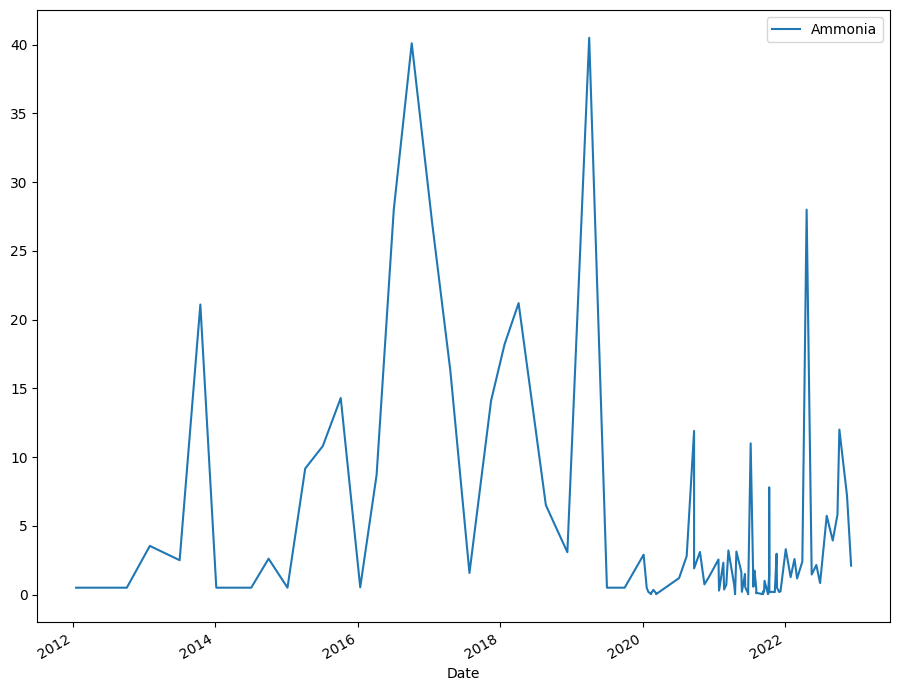

In [99]:
df.tail(100).plot()

In [96]:
!pip install statsmodels --upgrade

     |████████████████████████████████| 10.2 MB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 64.1 MB/s eta 0:00:01
ERROR: pymc3 3.11.5 has requirement numpy<1.22.2,>=1.15.0, but you'll have numpy 1.23.4 which is incompatible.
ERROR: pymc3 3.11.5 has requirement scipy<1.8.0,>=1.7.3, but you'll have scipy 1.9.3 which is incompatible.


In [97]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

%config Completer.use_jedi = False
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ImportError: cannot import name '_centered' from 'scipy.signal.signaltools' (/usr/local/lib/python3.8/dist-packages/scipy/signal/signaltools.py)

In [85]:
df.tail()

,Ammonia
Date,
2021-07-08 12:05:00,11.0
2021-10-11 10:49:00,7.8
2022-01-04 11:00:00,3.3
2022-04-21 11:07:00,28.0
2022-10-06 09:01:00,12.0


In [87]:
datasetTrain = df[:'2020-06-30']

datasetTest = df['2020-07-01':]

/tmp/ipykernel_17487/857585120.py:3: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  datasetTest = df['2020-07-01':]


In [89]:
datasetTest


,Ammonia
Date,
2020-11-17 11:23:00,1.7
2020-12-17 14:49:00,2.0
2021-01-07 12:35:00,2.2
2021-02-25 10:25:00,1.6
2021-03-16 12:50:00,2.3
...,...
2021-07-08 12:05:00,11.0
2021-10-11 10:49:00,7.8
2022-01-04 11:00:00,3.3


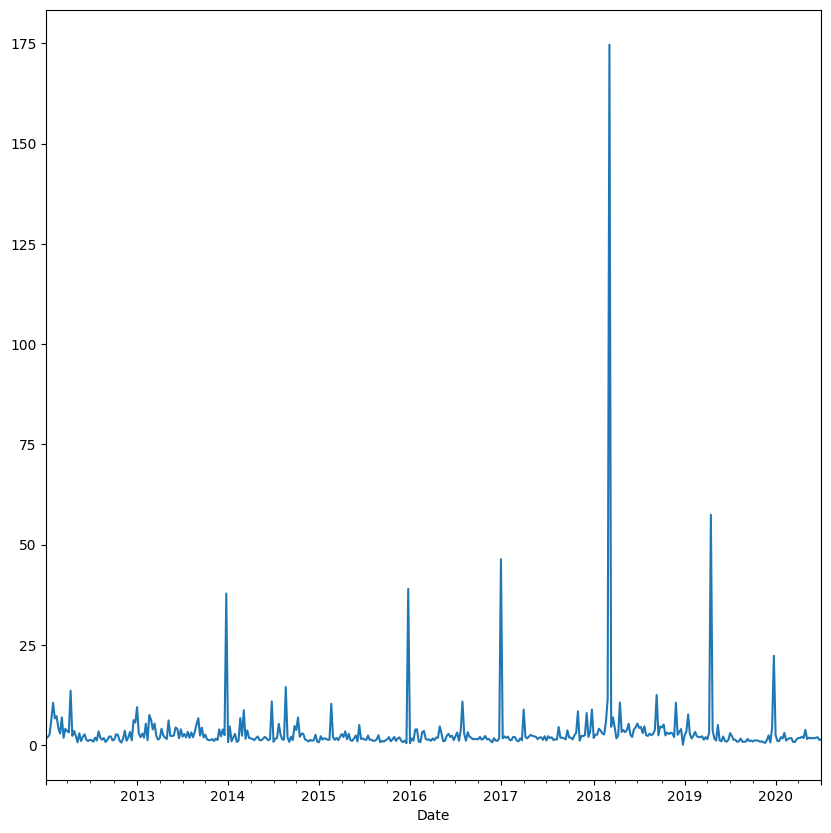

In [90]:
datasetTrain['Ammonia'].resample('W').mean().plot(figsize=(10, 10))
plt.show()

In [94]:
rcParams['figure.figsize'] = 11, 9

decomposition = sm.seasonal_decompose(datasetTrain.resample('W').mean()['Ammonia'], model='additive')
fig = decomposition.plot()
plt.show()

AttributeError: module 'statsmodels' has no attribute 'seasonal_decompose'